#  **Homework 3** TESLA Stock Predict Use LSTM

In [337]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

#print(plt.style.available)
#plt.style.use('seaborn-white')

## **1.1 mid-steps**: Load the data and inspect them

In [338]:
df = pd.read_csv('TSLA.csv')
print('Number of rows and columns: ', df.shape)
print(df.head(3))
print(df.tail(1))

Number of rows and columns:  (1259, 7)
         Date       Open       High        Low      Close  Adj Close    Volume
0  2015-07-10  52.444000  52.599998  51.563999  51.830002  51.830002  13054500
1  2015-07-13  52.450001  52.509998  51.209999  52.431999  52.431999  14801500
2  2015-07-14  52.419998  53.198002  52.102001  53.130001  53.130001   9538000
            Date       Open        High         Low       Close   Adj Close  \
1258  2020-07-09  279.39801  281.712006  270.256012  278.855988  278.855988   

        Volume  
1258  58588000  


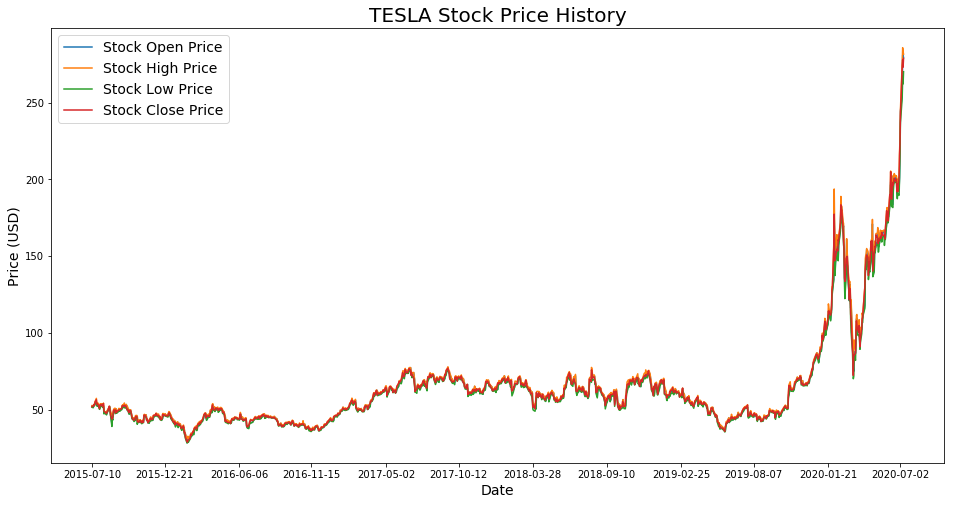

In [339]:
# Visualising the dataset
plt.figure(figsize = (16,8))

dates = df.loc[:, 'Date']
dates = list(dates)
dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates]
#print(date)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.plot(dates, df["Open"], label = 'Stock Open Price')
plt.plot(dates, df["High"], label = 'Stock High Price')
plt.plot(dates, df["Low"], label = 'Stock Low Price')
plt.plot(dates, df["Close"], label = 'Stock Close Price')

plt.xticks(dates[::114])
plt.title('TESLA Stock Price History', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

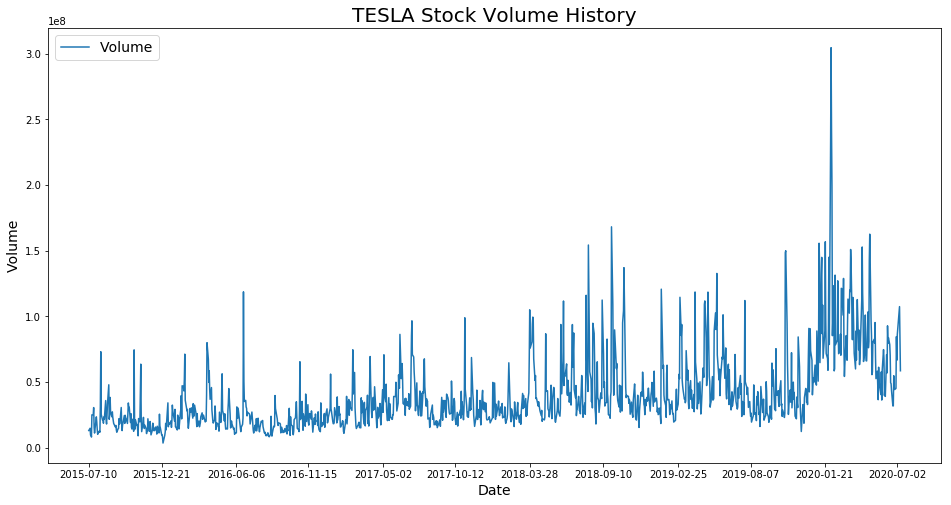

In [340]:
# Visualising the dataset
plt.figure(figsize = (16,8))

dates = df.loc[:, 'Date']
dates = list(dates)
dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates]
#print(date)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.plot(dates, df["Volume"])

plt.xticks(dates[::114])
plt.title('TESLA Stock Volume History', fontsize=20)
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## **1.2 mid-steps**: Split the data into training and test sets

In [341]:
#Use the 'Close' data at df
data_close = df.filter(['Close'])
data = data_close.values

#Feature Scaling
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

#Define split ratio
ratio = 0.80
seg_len = math.ceil(len(data) * ratio)
#Split the data into training and test sets
train_data = data_scaled[0 : seg_len, : ]
test_data = data_scaled[seg_len : , : ]

print("The train_data shape is: ", train_data.shape)
print("The test_data shape is: ", test_data.shape)

The train_data shape is:  (1008, 1)
The test_data shape is:  (251, 1)


## **1.3 mid-steps**: Build the input features with different time lags (1 day, 7 days, 14 days etc.)

In [342]:
#Build the input features with different time lags
def feature_embedding(data, time_lags):
    X = []
    y = []
    
    for i in range(time_lags, data.shape[0]):
        X.append(data[i-time_lags : i])
        y.append(data[i])
    
    assert len(X) == len(y)
    
    return np.array(X), np.array(y)

In [343]:
#Generate input for the model
#(1 day: 1, 7 days: 7, 14 days: 14, etc.)
time_lags = 14
X_train, y_train = feature_embedding(train_data, time_lags)
print("X_train shape is: ", X_train.shape)
print("y_train shape is: ", y_train.shape)

X_test, y_test = feature_embedding(test_data, time_lags)
print("X_test shape is: ", X_test.shape)
print("y_test shape is: ", y_test.shape)

X_train shape is:  (994, 14, 1)
y_train shape is:  (994, 1)
X_test shape is:  (237, 14, 1)
y_test shape is:  (237, 1)


## **1.4 mid-steps**: Build LSTM mode, decide how many neurons and how many layers, and design loss function and optimizer.

In [344]:
#Generate the LSTM model
def lstm_model(unit_num, drop_rate, hiden_layer_num):
    model = Sequential()

    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = unit_num, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(drop_rate))

    #Adding hiden LSTM layer and Dropout regularisation
    for i in range(0, hiden_layer_num-2):
        model.add(LSTM(units = unit_num, return_sequences = True))
        model.add(Dropout(drop_rate))

    model.add(LSTM(units = unit_num))
    model.add(Dropout(drop_rate))

    # Adding the output layer
    model.add(Dense(units = 1))
    
    return model

## **2.1 Results**: Make comparisons of different different hidden layer

### **Base model**: unit_num=50; drop_rate=0; batch size=32

### 2.1.1 hidden layer = 2

In [45]:
#Model parameter
unit_num = 50
drop_rate = 0.0

#hidden layer
hiden_layer_num = 2

# Generate model
model_2 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_2.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
994/994 [==============================] - 4s - loss: 0.0019 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 0s - loss: 2.6386e-04 - acc: 0.0010      
Epoch 3/100
994/994 [==============================] - 0s - loss: 1.8787e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 0s - loss: 1.8806e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 0s - loss: 1.6881e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 1s - loss: 1.6806e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 1s - loss: 1.5726e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 0s - loss: 1.5453e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 1s - loss: 1.4740e-04 - acc: 0.0010        
Epoch 10/100
994/994 [==============================] - 0s - loss: 1.5479e-04 - acc: 0.0010     
Epoch 11/100
994/994 [=================

### 2.1.2 hidden layer = 3

In [46]:
#hidden layer
hiden_layer_num = 3

# Generate model
model_3 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_3.summary()
# Compiling the LSTM
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_3.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
994/994 [==============================] - 5s - loss: 0.0023 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 1s - loss: 4.6929e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 1s - loss: 2.6235e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 1s - loss: 2.6807e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 1s - loss: 2.6545e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 1s - loss: 2.3263e-04 - acc: 0.0010      
Epoch 7/100
994/994 [==============================] - 1s - loss: 2.3657e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 1s - loss: 2.4168e-04 - acc: 0.0010      
Epoch 9/100
994/994 [==============================] - 1s - loss: 2.2133e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 1s - loss: 2.1718e-04 - acc: 0.0010     
Epoch 11/100
994/994 [===================

### 2.1.3 hidden layer = 4

In [47]:
#hidden layer
hiden_layer_num = 4

# Generate model
model_4 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_4.summary()
# Compiling the LSTM
model_4.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_4.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
994/994 [==============================] - 6s - loss: 0.0027 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 1s - loss: 4.7882e-04 - acc: 0.0010       
Epoch 3/100
994/994 [==============================] - 1s - loss: 3.4323e-04 - acc: 0.0010        
Epoch 4/100
994/994 [==============================] - 1s - loss: 3.3130e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 1s - loss: 2.7551e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 1s - loss: 2.7967e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 1s - loss: 2.5535e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 1s - loss: 2.5161e-04 - acc: 0.0010      
Epoch 9/100
994/994 [==============================] - 1s - loss: 2.6673e-04 - acc: 0.0010      
Epoch 10/100
994/994 [==============================] - 1s - loss: 2.3607e-04 - acc: 0.0010      
Epoch 11/100
994/994 [=============

### 2.1.4 hidden layer = 5

In [48]:
#hidden layer
hiden_layer_num = 5

# Generate model
model_5 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_5.summary()
# Compiling the LSTM
model_5.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_5.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
994/994 [==============================] - 7s - loss: 0.0026 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 2s - loss: 6.2369e-04 - acc: 0.0010        
Epoch 3/100
994/994 [==============================] - 2s - loss: 3.3485e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 2s - loss: 3.3373e-04 - acc: 0.0010        
Epoch 5/100
994/994 [==============================] - 2s - loss: 3.2100e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 2s - loss: 3.5990e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 2s - loss: 3.9475e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 2s - loss: 4.2123e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 2s - loss: 2.9024e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 2s - loss: 3.0896e-04 - acc: 0.0010        
Epoch 11/100
994/994 [============

994/994 [==============================] - 2s - loss: 4.4353e-05 - acc: 0.0010     
Epoch 86/100
994/994 [==============================] - 2s - loss: 5.2203e-05 - acc: 0.0010     
Epoch 87/100
994/994 [==============================] - 2s - loss: 4.7566e-05 - acc: 0.0010     
Epoch 88/100
994/994 [==============================] - 2s - loss: 4.7765e-05 - acc: 0.0010     
Epoch 89/100
994/994 [==============================] - 2s - loss: 5.7611e-05 - acc: 0.0010     
Epoch 90/100
994/994 [==============================] - 2s - loss: 7.6635e-05 - acc: 0.0010     
Epoch 91/100
994/994 [==============================] - 2s - loss: 5.0098e-05 - acc: 0.0010     
Epoch 92/100
994/994 [==============================] - 2s - loss: 5.2951e-05 - acc: 0.0010       
Epoch 93/100
994/994 [==============================] - 2s - loss: 4.3403e-05 - acc: 0.0010     
Epoch 94/100
994/994 [==============================] - 2s - loss: 4.9125e-05 - acc: 0.0010     
Epoch 95/100
994/994 [===================

In [49]:
predictions2 = model_2.predict(X_test)
predictions2 = scaler.inverse_transform(predictions2)
#print(predictions2.shape)

predictions3 = model_3.predict(X_test)
predictions3 = scaler.inverse_transform(predictions3)

predictions4 = model_4.predict(X_test)
predictions4 = scaler.inverse_transform(predictions4)

predictions5 = model_5.predict(X_test)
predictions5 = scaler.inverse_transform(predictions5)

### 2.1.5 visualize result comparsion

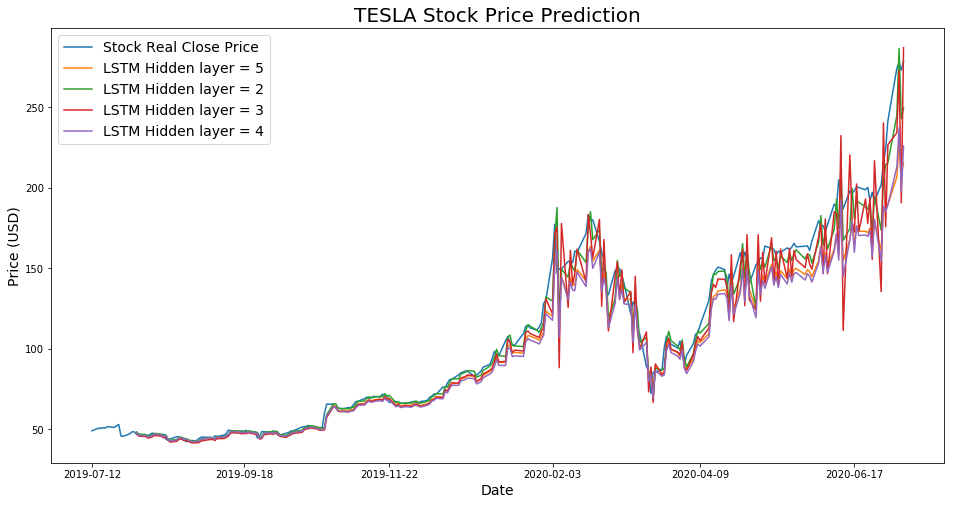

In [331]:
# Visualising the result
plt.figure(figsize = (16,8))

date_real = df.loc[seg_len : , 'Date']
date_pred = df.loc[seg_len+time_lags : , 'Date']
#print(date_real.shape)
#print(date_pred.shape)

dates_real = list(date_real)
dates_pred = list(date_pred)
dates_real = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_real]
dates_pred = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_pred]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
test_data = data[seg_len : , : ]

#print(test_data.shape)
plt.plot(dates_real, test_data, label = 'Stock Real Close Price')

plt.plot(dates_pred, predictions5, label = 'LSTM Hidden layer = 5')
plt.plot(dates_pred, predictions2, label = 'LSTM Hidden layer = 2')
plt.plot(dates_pred, predictions3, label = 'LSTM Hidden layer = 3')
plt.plot(dates_pred, predictions4, label = 'LSTM Hidden layer = 4')
plt.xticks(dates_real[::47])
plt.title('TESLA Stock Price Prediction', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## **2.2 Results**: Make comparisons of different different batch size

### **Base model**: unit_num=50; drop_rate=0; hiden_layer = 2

### 2.2.1 batch size = 8

In [57]:
#batch size
batch_size = 8

#Model parameter
unit_num = 50
drop_rate = 0.0

#hidden layer
hiden_layer_num = 2

# Generate model
model_b8 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_b8.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_b8.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 7s - loss: 3.9268e-04 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 3s - loss: 1.9122e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 3s - loss: 1.6868e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 3s - loss: 1.3665e-04 - acc: 0.0010         - E
Epoch 5/100
994/994 [==============================] - 3s - loss: 1.2706e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 3s - loss: 1.2257e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 3s - loss: 1.0040e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 3s - loss: 8.8536e-05 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 3s - loss: 9.1468e-05 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 3s - loss: 7.1493e-05 - acc: 0.0010     
Epoch 11/100
994/994 [==========

### 2.2.2 batch size = 16

In [58]:
#batch size
batch_size = 16

#Model parameter
unit_num = 50
drop_rate = 0.0

#hidden layer
hiden_layer_num = 2

# Generate model
model_b16 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_b16.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_b16.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 5s - loss: 8.3870e-04 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 1s - loss: 1.8740e-04 - acc: 0.0010       
Epoch 3/100
994/994 [==============================] - 1s - loss: 1.7436e-04 - acc: 0.0010        
Epoch 4/100
994/994 [==============================] - 1s - loss: 1.6705e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 1s - loss: 1.4539e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 1s - loss: 1.4944e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 1s - loss: 1.2573e-04 - acc: 0.0010        
Epoch 8/100
994/994 [==============================] - 1s - loss: 1.4343e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 1s - loss: 1.3432e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 1s - loss: 1.2108e-04 - acc: 0.0010     
Epoch 11/100
994/994 [=========

### 2.2.3 batch size = 32

In [59]:
#batch size
batch_size = 32

#Model parameter
unit_num = 50
drop_rate = 0.0

#hidden layer
hiden_layer_num = 2

# Generate model
model_b32 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_b32.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_b32.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 5s - loss: 0.0021 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 1s - loss: 3.0777e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 1s - loss: 1.9012e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 1s - loss: 1.9008e-04 - acc: 0.0010      
Epoch 5/100
994/994 [==============================] - 1s - loss: 1.7166e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 1s - loss: 1.7395e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 1s - loss: 1.6686e-04 - acc: 0.0010      
Epoch 8/100
994/994 [==============================] - 1s - loss: 1.6829e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 1s - loss: 1.4917e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 1s - loss: 1.5255e-04 - acc: 0.0010     
Epoch 11/100
994/994 [===================

### 2.2.4 batch size = 64

In [60]:
#batch size
batch_size = 64

#Model parameter
unit_num = 50
drop_rate = 0.0

#hidden layer
hiden_layer_num = 2

# Generate model
model_b64 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_b64.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_b64.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 4s - loss: 0.0041 - acc: 0.0010       
Epoch 2/100
994/994 [==============================] - 0s - loss: 9.6463e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 0s - loss: 4.8467e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 0s - loss: 2.1234e-04 - acc: 0.0010       
Epoch 5/100
994/994 [==============================] - 0s - loss: 2.0210e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 0s - loss: 1.9512e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 0s - loss: 1.8070e-04 - acc: 0.0010         
Epoch 8/100
994/994 [==============================] - 0s - loss: 1.7972e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 0s - loss: 1.7276e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 0s - loss: 1.6718e-04 - acc: 0.0010        
Epoch 11/100
994/994 [==========

In [190]:
predictions_b8 = model_b8.predict(X_test)
predictions_b8 = scaler.inverse_transform(predictions_b8)
print(predictions_b8.shape)

predictions_b16 = model_b16.predict(X_test)
predictions_b16 = scaler.inverse_transform(predictions_b16)

predictions_b32 = model_b32.predict(X_test)
predictions_b32 = scaler.inverse_transform(predictions_b32)

predictions_b64 = model_b32.predict(X_test)
predictions_b64 = scaler.inverse_transform(predictions_b64)


(237, 1)


### 2.2.5 batch size visualize result comparsion

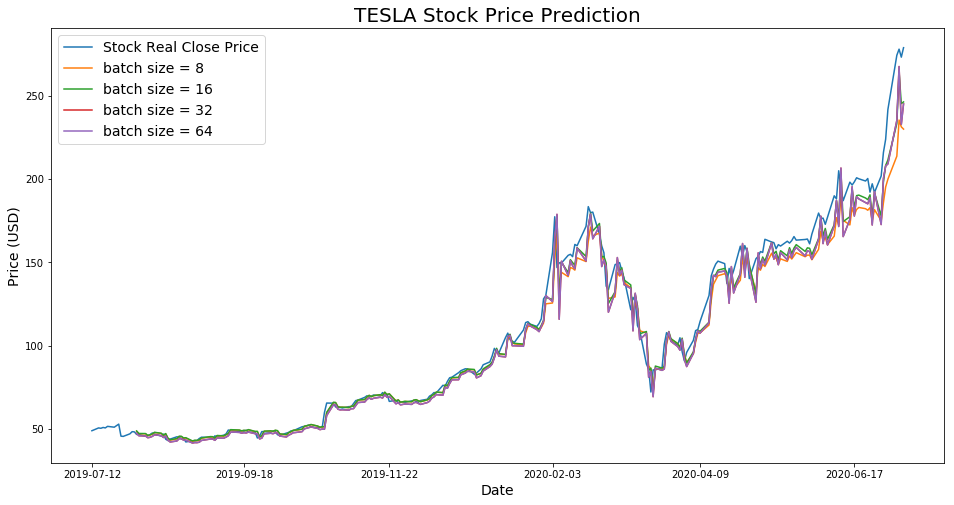

In [332]:
# Visualising the result
plt.figure(figsize = (16,8))

date_real = df.loc[seg_len : , 'Date']
date_pred = df.loc[seg_len+time_lags : , 'Date']
#print(date_real.shape)
#print(date_pred.shape)

dates_real = list(date_real)
dates_pred = list(date_pred)
dates_real = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_real]
dates_pred = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_pred]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
test_data = data[seg_len : , : ]

#print(test_data.shape)
plt.plot(dates_real, test_data, label = 'Stock Real Close Price')
plt.plot(dates_pred, predictions_b8, label = 'batch size = 8')
plt.plot(dates_pred, predictions_b16, label = 'batch size = 16')
plt.plot(dates_pred, predictions_b32, label = 'batch size = 32')
plt.plot(dates_pred, predictions_b64, label = 'batch size = 64')
plt.xticks(dates_real[::47])
plt.title('TESLA Stock Price Prediction', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## **2.3 Results**: Make comparisons of different drop out

### **Base model**: unit_num=50; drop_rate=0; hiden_layer = 2; batch size=32

### 2.3.1 drop out = 0.0

In [148]:
#drop out rate
drop_rate = 0.0

#batch size
batch_size = 32

#Model parameter
unit_num = 50

#hidden layer
hiden_layer_num = 4

# Generate model
model_d00 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_d00.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_d00.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 11s - loss: 0.0026 - acc: 0.0010       
Epoch 2/100
994/994 [==============================] - 2s - loss: 4.7780e-04 - acc: 0.0010     - ETA: 0s - loss: 5.4686e-04 - ac
Epoch 3/100
994/994 [==============================] - 2s - loss: 3.6416e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 2s - loss: 2.9108e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 2s - loss: 2.8010e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 2s - loss: 2.6221e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 2s - loss: 2.6371e-04 - acc: 0.0010     - ETA: 1s - loss: 2. - ETA: 0s - loss: 2.6601e-04 - acc: 0.00
Epoch 8/100
994/994 [==============================] - 2s - loss: 2.8683e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 2s - loss: 2.7868e-04 - acc: 0.0010     
Epoch 10/100
994/994 [=====================

### 2.3.2 drop out = 0.1

In [149]:
#drop out rate
drop_rate = 0.1

#batch size
batch_size = 32

#Model parameter
unit_num = 50

#hidden layer
hiden_layer_num = 4

# Generate model
model_d01 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_d01.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_d01.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 6s - loss: 0.0028 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 2s - loss: 7.5921e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 2s - loss: 4.3914e-04 - acc: 0.0010       
Epoch 4/100
994/994 [==============================] - 2s - loss: 3.7737e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 2s - loss: 3.5946e-04 - acc: 0.0010        
Epoch 6/100
994/994 [==============================] - 2s - loss: 3.1715e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 2s - loss: 3.4723e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 2s - loss: 3.4626e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 2s - loss: 3.6017e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 2s - loss: 3.0870e-04 - acc: 0.0010     
Epoch 11/100
994/994 [================

994/994 [==============================] - 2s - loss: 7.2086e-05 - acc: 0.0010     
Epoch 86/100
994/994 [==============================] - 2s - loss: 7.1724e-05 - acc: 0.0010     
Epoch 87/100
994/994 [==============================] - 1s - loss: 6.9018e-05 - acc: 0.0010     
Epoch 88/100
994/994 [==============================] - 2s - loss: 7.2251e-05 - acc: 0.0010     
Epoch 89/100
994/994 [==============================] - 2s - loss: 7.6657e-05 - acc: 0.0010     
Epoch 90/100
994/994 [==============================] - 2s - loss: 6.8708e-05 - acc: 0.0010     
Epoch 91/100
994/994 [==============================] - 2s - loss: 6.6273e-05 - acc: 0.0010     
Epoch 92/100
994/994 [==============================] - 2s - loss: 6.9743e-05 - acc: 0.0010     
Epoch 93/100
994/994 [==============================] - 2s - loss: 7.0605e-05 - acc: 0.0010     
Epoch 94/100
994/994 [==============================] - 2s - loss: 7.7541e-05 - acc: 0.0010     
Epoch 95/100
994/994 [=====================

### 2.3.3 drop out = 0.2

In [150]:
#drop out rate
drop_rate = 0.2

#batch size
batch_size = 32

#Model parameter
unit_num = 50

#hidden layer
hiden_layer_num = 4

# Generate model
model_d02 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_d02.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_d02.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 6s - loss: 0.0027 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 2s - loss: 5.8987e-04 - acc: 0.0010       
Epoch 3/100
994/994 [==============================] - 2s - loss: 4.4240e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 2s - loss: 4.7741e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 2s - loss: 4.1945e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 2s - loss: 3.7194e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 2s - loss: 3.8259e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 2s - loss: 3.3444e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 2s - loss: 3.1542e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 2s - loss: 3.4183e-04 - acc: 0.0010     
Epoch 11/100
994/994 [===================

### 2.3.4 drop out = 0.3

In [151]:
#drop out rate
drop_rate = 0.3

#batch size
batch_size = 32

#Model parameter
unit_num = 50

#hidden layer
hiden_layer_num = 4

# Generate model
model_d03 = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model_d03.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model_d03.fit(X_train, y_train, epochs = 100, batch_size = batch_size)

Epoch 1/100
994/994 [==============================] - 9s - loss: 0.0029 - acc: 0.0010     
Epoch 2/100
994/994 [==============================] - 2s - loss: 7.4748e-04 - acc: 0.0010        
Epoch 3/100
994/994 [==============================] - 2s - loss: 5.5856e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 2s - loss: 4.4039e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 2s - loss: 4.5271e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 2s - loss: 4.0282e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 2s - loss: 3.9482e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 2s - loss: 3.9035e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 2s - loss: 3.9416e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 2s - loss: 4.1034e-04 - acc: 0.0010     
Epoch 11/100
994/994 [==================

In [182]:
predictions_d00 = model_d00.predict(X_test)
predictions_d00 = scaler.inverse_transform(predictions_d00)

predictions_d01 = model_d01.predict(X_test)
predictions_d01 = scaler.inverse_transform(predictions_d01)

predictions_d02 = model_d02.predict(X_test)
predictions_d02 = scaler.inverse_transform(predictions_d02)

predictions_d03 = model_d03.predict(X_test)
predictions_d03 = scaler.inverse_transform(predictions_d03)

### 2.3.5 drop out visualize result comparsion

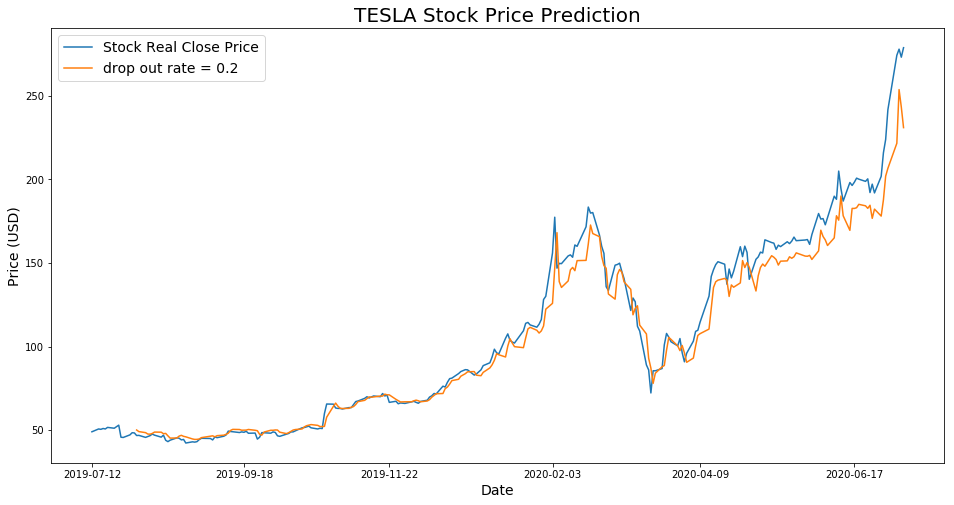

In [359]:
# Visualising the result
plt.figure(figsize = (16,8))

date_real = df.loc[seg_len : , 'Date']
date_pred = df.loc[seg_len+time_lags : , 'Date']
#print(date_real.shape)
#print(date_pred.shape)

dates_real = list(date_real)
dates_pred = list(date_pred)
dates_real = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_real]
dates_pred = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_pred]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
test_data = data[seg_len : , : ]

#print(test_data.shape)
plt.plot(dates_real, test_data, label = 'Stock Real Close Price')
#plt.plot(dates_pred, predictions_d00, label = 'drop out rate = 0.0')
#plt.plot(dates_pred, predictions_d01, label = 'drop out rate = 0.1')
plt.plot(dates_pred, predictions_d02, label = 'drop out rate = 0.2')
#plt.plot(dates_pred, predictions_d03, label = 'drop out rate = 0.3')

plt.xticks(dates_real[::47])
plt.title('TESLA Stock Price Prediction', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## **3.1 Results**: Visualize the results.

In [357]:
#Model parameter
unit_num = 50
drop_rate = 0.2

#hidden layer
hiden_layer_num = 4

# Generate model
model = lstm_model(unit_num, drop_rate, hiden_layer_num)
#model_2.summary()
# Compiling the LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the LSTM to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
994/994 [==============================] - 13s - loss: 0.0024 - acc: 0.0010    
Epoch 2/100
994/994 [==============================] - 4s - loss: 4.2708e-04 - acc: 0.0010     
Epoch 3/100
994/994 [==============================] - 4s - loss: 3.0419e-04 - acc: 0.0010     
Epoch 4/100
994/994 [==============================] - 4s - loss: 3.0874e-04 - acc: 0.0010     
Epoch 5/100
994/994 [==============================] - 4s - loss: 2.8344e-04 - acc: 0.0010     
Epoch 6/100
994/994 [==============================] - 4s - loss: 2.9725e-04 - acc: 0.0010     
Epoch 7/100
994/994 [==============================] - 4s - loss: 3.0157e-04 - acc: 0.0010     
Epoch 8/100
994/994 [==============================] - 4s - loss: 3.0713e-04 - acc: 0.0010     
Epoch 9/100
994/994 [==============================] - 4s - loss: 2.6180e-04 - acc: 0.0010     
Epoch 10/100
994/994 [==============================] - 4s - loss: 2.5102e-04 - acc: 0.0010     
Epoch 11/100
994/994 [=====================

In [360]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

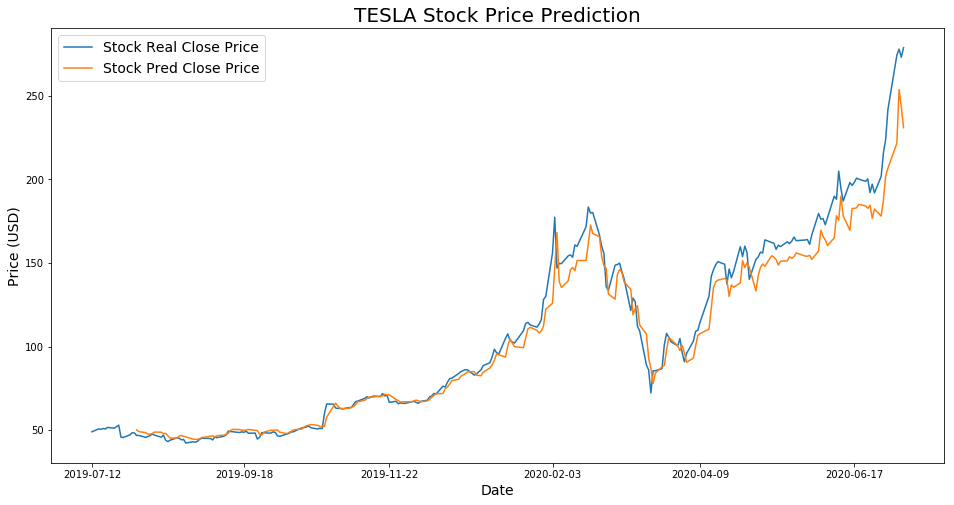

In [362]:
# Visualising the result
plt.figure(figsize = (16,8))

date_real = df.loc[seg_len : , 'Date']
date_pred = df.loc[seg_len+time_lags : , 'Date']
#print(date_real.shape)
#print(date_pred.shape)

dates_real = list(date_real)
dates_pred = list(date_pred)
dates_real = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_real]
dates_pred = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates_pred]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
test_data = data[seg_len : , : ]
#print(test_data.shape)
plt.plot(dates_real, test_data, label = 'Stock Real Close Price')
plt.plot(dates_pred, predictions, label = 'Stock Pred Close Price')

plt.xticks(dates_real[::47])
plt.title('TESLA Stock Price Prediction', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## **3.2 Results**: Using the data provided, make predictions for future two weeks, until Oct 2020. 

### In the test set, we use the accurate input to predict the daily stock price, but in the actual prediction of the model, since the input is the predicted value of the model, the daily prediction error may cause the subsequent prediction error to gradually increase.

In [368]:
#Total days of 2020-07-10 to 2020-10-01. Note: weekends not included.
time_len = 59

predict_list = []
for i in range(0, time_lags):
    predict_list.append(data_scaled[data_scaled.shape[0] - time_lags + i][0])
#print(predict_list)

for i in range(0, time_len):
    x_test = []
    x_test.append(predict_list[i : i+time_lags])
    
    x_test = np.array(x_test).reshape(1, -1, 1)
    pred = model.predict(x_test)
    predict_list.append(pred)

predict_list = predict_list[time_lags : ]
predict_list = np.array(predict_list).reshape(-1, 1)
predictions = scaler.inverse_transform(predict_list)

In [369]:
df_date = pd.read_csv('Date.csv')

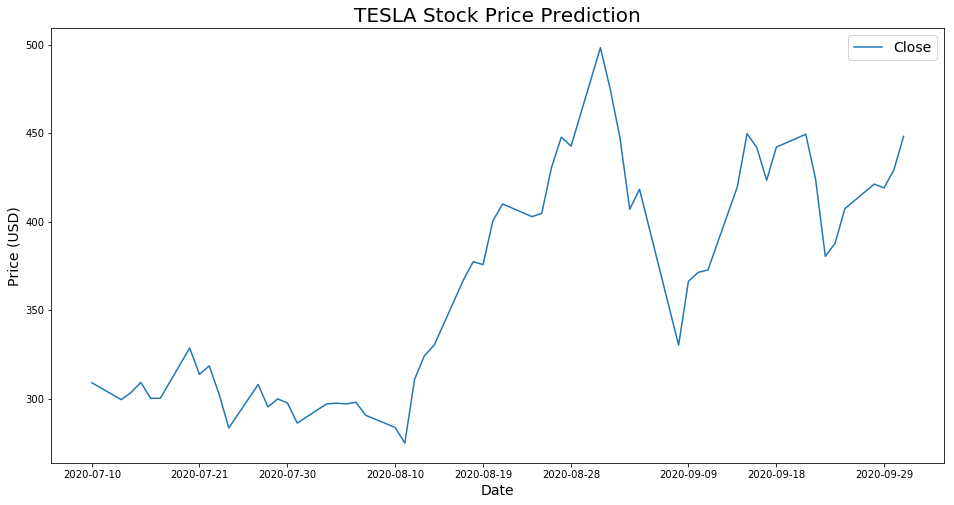

In [370]:
# Visualising the result
plt.figure(figsize = (16,8))

date_pred = df_date.loc[0 : 58, 'Date']
#print(date_pred.shape)

dates_pred = list(date_pred)
#print(dates_pred)
dates_pred = [datetime.strptime(d, '%Y/%m/%d').date() for d in dates_pred]

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.plot(dates_pred, predictions)

plt.xticks(dates_pred[::7])
plt.title('TESLA Stock Price Prediction', fontsize=20)
plt.ylabel('Price (USD)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(fontsize=14)
plt.show()
